In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras_preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Conv1D,MaxPooling1D, Input, Concatenate, Reshape, Bidirectional,Flatten
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import pickle
import networkx as nx
import penman
from karateclub import Graph2Vec

/DATA/gupta37/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
2023-07-05 17:37:12.846194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 17:37:13.023140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-05 17:37:13.023183: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-05 17:37:13.941

In [2]:
train_df=pd.read_csv(r'./covid_dataset/Constraint_English_Train - Sheet1.csv')
dev_df=pd.read_csv(r'./covid_dataset/Constraint_English_Val - Sheet1.csv')
test_df=pd.read_csv(r'./covid_dataset/english_test_with_labels - Sheet1.csv')


In [3]:
# Concatenate the dataframes vertically
df = pd.concat([train_df, dev_df, test_df], axis=0)

# Reset the index of the combined dataframe
df.reset_index(drop=True, inplace=True)

In [4]:
df['label'] = df['label'].replace({'real': 1, 'fake': 0})

In [5]:
df['tweet']= df['tweet'].apply(lambda x: re.sub(r'[\n\r;@#~.!"()%]|http[s]?://\S+|', '', x))

In [6]:
len(df)

10700

In [7]:
df['no_of_sent']= df['tweet'].apply(lambda x: len(sent_tokenize(x)))

In [8]:
df[df['label']==1]

,id,tweet,label,no_of_sent
0,1,The CDC currently reports 99031 deaths In gene...,1,1
1,2,States reported 1121 deaths a small rise from ...,1,1
3,4,IndiaFightsCorona: We have 1524 COVID testing ...,1,1
4,5,Populous states can generate large case counts...,1,1
5,6,Covid Act Now found on average each person in ...,1,1
...,...,...,...,...
10693,2134,RT WHOAFRO: The COVID19 virus hasn't been foun...,1,1
10695,2136,CoronaVirusUpdates: State-wise details of Tota...,1,1
10697,2138,296 new cases of COVID19Nigeria Plateau-85 Enu...,1,1
10698,2139,RT CDCemergency: DYK? CDCgov’s One-Stop Shop f...,1,2


In [9]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [10]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['tweet']=df['tweet'].apply(denoise_text)

/DATA/gupta37/.local/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [11]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.tweet)


In [12]:
def get_max_len(text):
    words_len = []
    for i in text:
        words=[]
        for j in i.split():
            words.append(j.strip())
        words_len.append(len(words))
    return words_len
max_len = max(get_max_len(df.tweet))

In [13]:
max_len

888

# Glove Emebedding

In [14]:
x_train,x_test,y_train,y_test = train_test_split(df.tweet,df.label,random_state = 42)

In [15]:
max_features = 8231
maxlen = 100
max_sent_len=7

In [16]:

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [17]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [18]:
EMBEDDING_FILE = './glove.twitter.27B.100d.txt'

In [19]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [20]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/DATA/gupta37/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# Graph Embedding

In [26]:
with open('covid_fake_amr_graph_lst.pkl', 'rb') as f:
    graphs_list = pickle.load(f)

In [27]:
len(graphs_list)

11739

In [28]:
g_model = Graph2Vec(dimensions=100)
g_model.fit(graphs_list)
g2ve=g_model.get_embedding()

# Creating matrix with size (max_sen_len,100)

In [29]:
g2ve_list=[]
for i in (df.index):
    g2ve_list.append([g2ve[j] for j in range(i,i+df['no_of_sent'][i])])
    g2ve=np.delete(g2ve,np.arange(i+1,i+df['no_of_sent'][i]),axis=0)

In [30]:
len(g2ve)

10700

In [31]:
for i in (df.index):
    if df['no_of_sent'][i] == 0:
        padded_vector = np.zeros((max_sent_len, 100))
        g2ve_list[i] = padded_vector
    elif df['no_of_sent'][i] < max_sent_len:
        padded_vector = np.zeros((max_sent_len, 100))
        padded_vector[:df['no_of_sent'][i], :] = g2ve_list[i]
        g2ve_list[i] = padded_vector
    else:
        padded_vector = np.zeros((max_sent_len, 100))
        padded_vector[:max_sent_len, :] = g2ve_list[i][:max_sent_len]
        g2ve_list[i] = padded_vector

In [32]:
#max([len(i) for i in g2ve_list])

# mean vector

In [33]:
# for i in (df[df['no_of_sent']>1].index):
#     g2ve[i]=np.mean(g2ve[i:i+df['no_of_sent'][i]],axis=0)
#     g2ve=np.delete(g2ve,np.arange(i+1,i+df['no_of_sent'][i]),axis=0)
    

In [34]:
x_g_train,x_g_test,y_g_train,y_g_test = train_test_split(g2ve_list,df.label,random_state = 42)

# CNN

In [35]:
batch_size = 256
epochs = 200
embed_size = 100

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [37]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [119]:
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
layer1 =Conv1D(filters=128, kernel_size=3, activation='relu')(embed1)
layer2 = MaxPooling1D(pool_size=2)(layer1)
layer3 = Flatten()(layer2)
layer4 = Dropout(0.8)(layer3)
layer5 = Dense(1, activation='sigmoid')(layer4)
model_cnn = Model(input1, layer5)
model_cnn.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/DATA/gupta37/.local/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [120]:
model_cnn.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 100, 100)          823100    
                                                                 
 conv1d_4 (Conv1D)           (None, 98, 128)           38528     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 49, 128)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_6 (Dropout)         (None, 6272)              0         
                                                           

In [121]:
history_cnn = model_cnn.fit(x_train, y_train, batch_size = batch_size , validation_split = .2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 1.0407 - accuracy: 0.6903WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa3140a6d90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

26/26 [==============================] - 1s 26ms/step - loss: 0.1831 - accuracy: 0.9280 - val_loss: 0.2516 - val_accuracy: 0.8978 - lr: 3.9062e-05
Epoch 33/200
26/26 [==============================] - 1s 26ms/step - loss: 0.1830 - accuracy: 0.9268 - val_loss: 0.2516 - val_accuracy: 0.8978 - lr: 1.9531e-05
Epoch 34/200
24/26 [==========================>...] - ETA: 0s - loss: 0.1916 - accuracy: 0.9250
Epoch 34: ReduceLROnPlateau reducing learning rate to 1e-05.
26/26 [==============================] - 1s 28ms/step - loss: 0.1907 - accuracy: 0.9249 - val_loss: 0.2515 - val_accuracy: 0.8978 - lr: 1.9531e-05
Epoch 35/200
26/26 [==============================] - 1s 27ms/step - loss: 0.1817 - accuracy: 0.9287 - val_loss: 0.2515 - val_accuracy: 0.8984 - lr: 1.0000e-05
Epoch 36/200
26/26 [==============================] - 1s 27ms/step - loss: 0.1766 - accuracy: 0.9336 - val_loss: 0.2515 - val_accuracy: 0.8984 - lr: 1.0000e-05
Epoch 37/200
26/26 [==============================] - 1s 28ms/step - 

In [122]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype("int32")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - 0s 3ms/step


In [123]:
accuracy_score(y_test,y_pred)

0.9121495327102803

In [124]:
from sklearn.metrics import classification_report

In [125]:
print(classification_report(y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.88931   0.92829   0.90838      1255
           1    0.93407   0.89789   0.91562      1420

    accuracy                        0.91215      2675
   macro avg    0.91169   0.91309   0.91200      2675
weighted avg    0.91307   0.91215   0.91222      2675



In [126]:
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
input2=Input(shape=(max_sent_len,100,))
#reshaped_input_2 = Reshape((1, 100))(input2)
feature =  Concatenate(axis=1)([embed1, input2])
layer1 =Conv1D(filters=128, kernel_size=3, activation='relu')(feature)
layer2 = MaxPooling1D(pool_size=2)(layer1)
layer3 = Flatten()(layer2)
layer4 = Dropout(0.8)(layer3)
layer5 = Dense(1, activation='sigmoid')(layer4)
model_cnn_graph = Model([input1, input2], layer5)
model_cnn_graph.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/DATA/gupta37/.local/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [127]:
model_cnn_graph.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 100, 100)     823100      ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 7, 100)]     0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 107, 100)     0           ['embedding_9[0][0]',            
                                                                  'input_14[0][0]']         

In [131]:
history_cnn_graph = model_cnn_graph.fit([x_train,np.array(x_g_train)], y_train, batch_size = batch_size , validation_split = .2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping], steps_per_epoch=len(x_train) // 32)

Epoch 1/200
250/250 [==============================] - 6s 25ms/step - loss: 0.1670 - accuracy: 0.9342 - val_loss: 0.2333 - val_accuracy: 0.9072 - lr: 0.0025
Epoch 2/200
250/250 [==============================] - 6s 24ms/step - loss: 0.1359 - accuracy: 0.9469 - val_loss: 0.2341 - val_accuracy: 0.9109 - lr: 0.0025
Epoch 3/200
250/250 [==============================] - 6s 24ms/step - loss: 0.1177 - accuracy: 0.9537 - val_loss: 0.2471 - val_accuracy: 0.9084 - lr: 0.0025
Epoch 4/200
249/250 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9585
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
250/250 [==============================] - 6s 25ms/step - loss: 0.1070 - accuracy: 0.9585 - val_loss: 0.2450 - val_accuracy: 0.9097 - lr: 0.0025
Epoch 5/200
250/250 [==============================] - 6s 25ms/step - loss: 0.0920 - accuracy: 0.9653 - val_loss: 0.2452 - val_accuracy: 0.9103 - lr: 0.0012
Epoch 6/200
250/250 [==============================] -

In [132]:
y_pred = (model_cnn_graph.predict([X_test,np.array(x_g_test)]) > 0.5).astype("int32")

84/84 [==============================] - 0s 3ms/step


In [133]:
accuracy_score(y_test,y_pred)

0.9271028037383178

In [134]:
print(classification_report(y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.91277   0.93386   0.92320      1255
           1    0.94033   0.92113   0.93063      1420

    accuracy                        0.92710      2675
   macro avg    0.92655   0.92750   0.92691      2675
weighted avg    0.92740   0.92710   0.92714      2675



# CLSTM

In [46]:
#Defining Neural Network
# model = Sequential()
#Non-trainable embeddidng layer
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
layer1 =Conv1D(filters=128, kernel_size=3, activation='relu')(embed1)
layer2 = MaxPooling1D(pool_size=2)(layer1)
layer3 = LSTM(units=100, recurrent_dropout = 0.25 , dropout = 0.2)(layer2)
layer4 = Dense(1, activation='sigmoid')(layer3)
model_clstm = Model(input1, layer4)
model_clstm.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/DATA/gupta37/.local/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [47]:
model_clstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          823100    
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 128)           38528     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 49, 128)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 100)               91600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                           

In [48]:
history_csltm = model_clstm.fit(x_train, y_train, batch_size = batch_size , validation_split = 0.2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/26 [===========================>..] - ETA: 0s - loss: 0.5182 - accuracy: 0.7406WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbb63632510> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

In [49]:
y_pred_clstm = (model_clstm.predict(X_test) > 0.2).astype("int32")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - 1s 12ms/step


In [50]:
accuracy_score(y_test,y_pred_clstm)

0.8871028037383177

In [51]:
print(classification_report(y_test, y_pred_clstm,digits=5))

              precision    recall  f1-score   support

           0    0.95166   0.80000   0.86926      1255
           1    0.84506   0.96408   0.90066      1420

    accuracy                        0.88710      2675
   macro avg    0.89836   0.88204   0.88496      2675
weighted avg    0.89507   0.88710   0.88593      2675



In [ ]:
# input1=Input(shape=(maxlen,))
# embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)

# #reshaped_input_2 = Reshape((1, 100))(input2)

# #reshaped_data = Reshape((200, 1))(feature)
# layer1 = Conv1D(filters=128, kernel_size=3, activation='relu',input_dim=2)(embed1)
# layer2 = MaxPooling1D(pool_size=2)(layer1)
# layer3 = LSTM(units=100 , recurrent_dropout = 0.25 , dropout = 0.2)(layer2)
# input2=Input(shape=(100,))
# feature =  Concatenate(axis=1)([layer3, input2])
# layer4 = Dense(1, activation='sigmoid')(feature)
# model_clstm_graph = Model([input1, input2], layer4)

# model_clstm_graph.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
input2=Input(shape=(max_sent_len,100,))
#reshaped_input_2 = Reshape((1, 100))(input2)
feature =  Concatenate(axis=1)([embed1, input2])
#reshaped_data = Reshape((200, 1))(feature)
layer1 = Conv1D(filters=128, kernel_size=3, activation='relu',input_dim=2)(feature)
layer2 = MaxPooling1D(pool_size=2)(layer1)
layer3 = LSTM(units=100 , recurrent_dropout = 0.25 , dropout = 0.2)(layer2)
layer4 = Dense(1, activation='sigmoid')(layer3)
model_clstm_graph = Model([input1, input2], layer4)

model_clstm_graph.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model_clstm_graph.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     823100      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 7, 100)]     0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 107, 100)     0           ['embedding_1[0][0]',            
                                                                  'input_4[0][0]']          

In [40]:
history_clstm_graph = model_clstm_graph.fit([x_train,np.array(x_g_train)], y_train, batch_size = batch_size , validation_split = .2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping], steps_per_epoch=len(x_train) // 32)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9199WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbb619dbea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

In [41]:
y_pred_clstm_graph = (model_clstm_graph.predict([X_test,np.array(x_g_test)]) > 0.9).astype("int32")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - 1s 13ms/step


In [42]:
accuracy_score(y_test,y_pred_clstm_graph)

0.9226168224299065

In [44]:
print(classification_report(y_test, y_pred_clstm_graph,digits=5))

              precision    recall  f1-score   support

           0    0.90184   0.93705   0.91911      1255
           1    0.94238   0.90986   0.92583      1420

    accuracy                        0.92262      2675
   macro avg    0.92211   0.92346   0.92247      2675
weighted avg    0.92336   0.92262   0.92268      2675



In [52]:
model2_correct_indices=[]
for i in range(len(list(y_test))):
    if list(y_test)[i] != y_pred_clstm[i] and list(y_test)[i] == y_pred_clstm_graph[i]:
        model2_correct_indices.append(i)

print("Indices where only Model 2 has correct predictions:")
print(model2_correct_indices)

Indices where only Model 2 has correct predictions:
[30, 73, 74, 77, 86, 87, 124, 139, 146, 157, 190, 198, 212, 228, 253, 254, 263, 280, 303, 318, 320, 362, 364, 368, 415, 417, 420, 480, 492, 499, 504, 509, 516, 523, 543, 569, 573, 602, 604, 628, 632, 634, 642, 677, 701, 727, 735, 766, 768, 796, 798, 817, 820, 846, 861, 889, 905, 912, 926, 927, 941, 947, 953, 962, 968, 976, 978, 981, 988, 990, 1000, 1008, 1009, 1039, 1063, 1066, 1084, 1101, 1102, 1116, 1126, 1133, 1141, 1142, 1144, 1153, 1168, 1172, 1180, 1204, 1240, 1265, 1285, 1299, 1310, 1333, 1335, 1339, 1363, 1373, 1391, 1399, 1400, 1418, 1423, 1436, 1443, 1444, 1482, 1483, 1486, 1488, 1510, 1512, 1518, 1520, 1522, 1537, 1551, 1597, 1627, 1679, 1682, 1692, 1707, 1710, 1711, 1721, 1735, 1738, 1754, 1757, 1766, 1775, 1789, 1790, 1803, 1834, 1839, 1844, 1857, 1883, 1917, 1923, 1939, 1955, 1989, 1993, 2000, 2002, 2013, 2026, 2034, 2043, 2045, 2062, 2073, 2086, 2103, 2131, 2140, 2146, 2170, 2181, 2187, 2203, 2208, 2225, 2238, 2252, 227

In [55]:


# Create the intermediate model to extract feature vector
text_layer_featutres = Model(inputs=model_clstm_graph.input, outputs=model_clstm_graph.get_layer('embedding_1').output)
amr_layer_featutres = Model(inputs=model_clstm_graph.input, outputs=model_clstm_graph.get_layer('input_4').output)
text_amr_layer_featutres = Model(inputs=model_clstm_graph.input, outputs=model_clstm_graph.get_layer('concatenate_1').output)


In [56]:
text_feature_vector = text_layer_featutres.predict([X_test,np.array(x_g_test)])
amr_feature_vector = amr_layer_featutres.predict([X_test,np.array(x_g_test)])
text_amr_feature_vector = text_amr_layer_featutres.predict([X_test,np.array(x_g_test)])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - 0s 1ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report 

In [57]:
len(amr_feature_vector)

2675

In [110]:
print(list(y_test)[30], y_pred_clstm[30], y_pred_clstm_graph[30])

0 [1] [0]


In [120]:
[X_test,np.array(x_g_test)][1][30]

array([[ 0.03137232,  0.06711751,  0.02044488, -0.03822739, -0.0107991 ,
         0.02188032, -0.00087005, -0.03542587, -0.03563093, -0.0083448 ,
        -0.01886936, -0.06899377,  0.04593752,  0.03458804,  0.01170159,
         0.05758818,  0.03316605, -0.01884029, -0.01341788,  0.02556938,
         0.02666711,  0.01691762,  0.09655944,  0.04338883,  0.06570669,
        -0.00067764, -0.0449577 , -0.07833739,  0.09732731, -0.00097456,
        -0.07924827, -0.02149149,  0.00462181,  0.03570174, -0.07662674,
         0.01008137, -0.13839948,  0.12497722, -0.00591132,  0.04932652,
        -0.03011743, -0.06146292, -0.02275738,  0.11232427,  0.02398733,
         0.03886502,  0.00360268,  0.05966533,  0.0684947 ,  0.12823166,
        -0.00456704,  0.01467984, -0.02991278, -0.0523587 , -0.03838616,
        -0.04075903, -0.0624545 , -0.05003711,  0.03346669, -0.04810331,
         0.12707549,  0.07610152, -0.05656109, -0.01125887,  0.15182345,
         0.03701625,  0.00091872,  0.00116573,  0.0

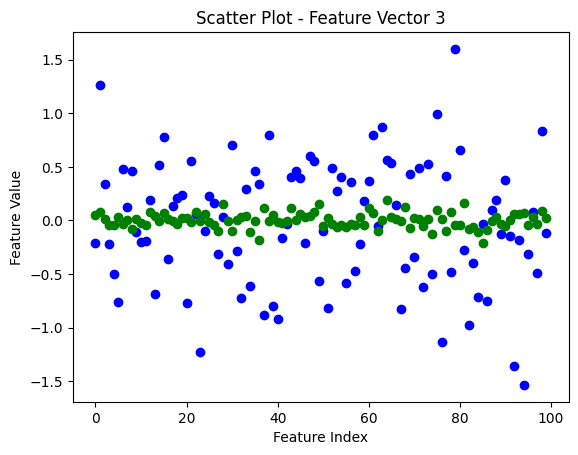

In [58]:
import matplotlib.pyplot as plt

# Assuming you have your feature vectors stored in variables 'feature_vector1' and 'feature_vectors3'
# Assuming you have your true labels stored in variables 'labels1' and 'labels3'

# # Scatter plot for feature_vector1
# plt.scatter(range(len(text_feature_vector[2629][5])), text_feature_vector[2629][5], c='blue')
# plt.xlabel('Feature Index')
# plt.ylabel('Feature Value')
# #plt.ylim(-0.2, 0.15)
# plt.title('Scatter Plot - Feature Vector 1')

# plt.show()


# plt.scatter(range(len(amr_feature_vector[2629][0])),  amr_feature_vector[2629][0],
#             c='green')

# plt.xlabel('Feature Index')
# plt.ylabel('Feature Value')
# plt.title('Scatter Plot - Feature Vector 2')

# plt.show()

# Scatter plot for feature_vector1
#plt.scatter(range(len([X_test,np.array(x_g_test)][0][910])+len([X_test,np.array(x_g_test)][1][910][1])), np.concatenate(([X_test,np.array(x_g_test)][0][910], [X_test,np.array(x_g_test)][1][910][0]),axis=0), cmap='viridis')

plt.scatter(range(len(text_amr_feature_vector[1738][:100][5])), text_amr_feature_vector[1738][:100][5],c='blue')
plt.scatter(range(len(text_amr_feature_vector[1738][100:][0])), text_amr_feature_vector[1738][100:][0],c='green')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Scatter Plot - Feature Vector 3')

plt.show()


# # Scatter plot for feature_vectors3
# for i in range(len(feature_vectors3)):
#     plt.scatter(range(len(x_train[30])), feature_vectors3[i], c=labels3[i], cmap='viridis')
# plt.xlabel('Feature Index')
# plt.ylabel('Feature Value')
# plt.title('Scatter Plot - Feature Vector 3')
# plt.colorbar(label='True Labels')
# plt.show()


In [77]:
feature_vector_2[1]

0.075607635

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

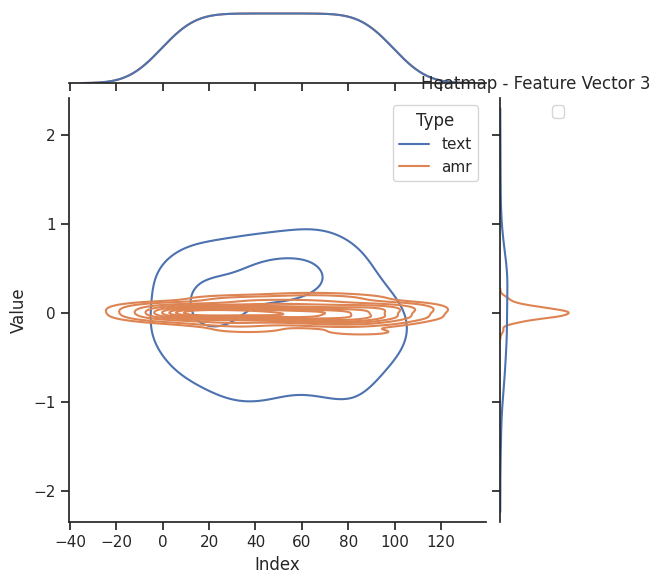

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

#
# Create a heatmap
plt.figure(figsize=(10, 6))
g = sns.jointplot(
    data=df,
    x="Index", y="Value",hue="Type",kind='kde'
)

# Set labels and title
plt.xlabel('Feature Index')
plt.ylabel('Feature Vector')
plt.legend()
plt.title('Heatmap - Feature Vector 3')

# Show the plot
plt.show()


In [74]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [121]:
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [170]:
import pandas as pd

# Create a list of dictionaries for each row
data1 = [{'Value': value, 'Index': index, 'Type': 'text'} for index, value in enumerate(text_amr_feature_vector[1738][:100][90])]
data1 += [{'Value': value, 'Index': index, 'Type': 'amr'} for index, value in enumerate(text_amr_feature_vector[1738][100:][0])]
data2 = [{'Value': value, 'Index': index, 'Type': 'text'} for index, value in enumerate(text_amr_feature_vector[1373][:100][92])]
data2 += [{'Value': value, 'Index': index, 'Type': 'amr'} for index, value in enumerate(text_amr_feature_vector[1373][100:][0])]
data3 = [{'Value': value, 'Index': index, 'Type': 'text'} for index, value in enumerate(text_amr_feature_vector[1444][:100][99])]
data3 += [{'Value': value, 'Index': index, 'Type': 'amr'} for index, value in enumerate(text_amr_feature_vector[1444][100:][0])]

# Create a DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
# Display the DataFrame
#print(df)


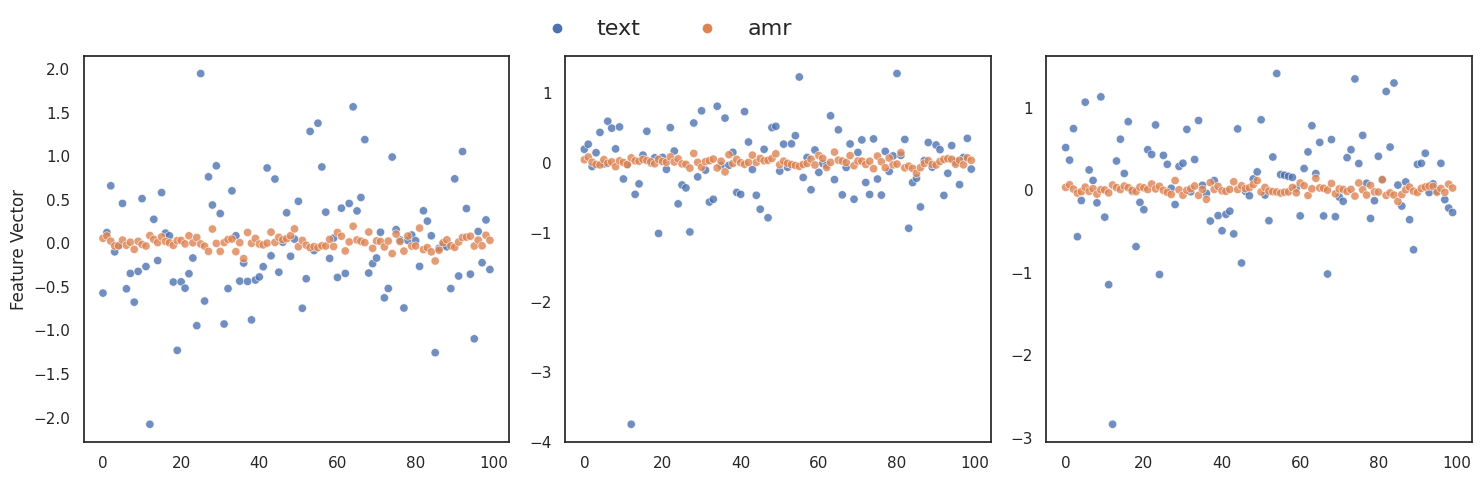

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Iterate over each dataframe and corresponding axis
for i, (data, ax) in enumerate(zip([df1, df2, df3], axes)):
    sns.scatterplot(data=data, x="Index", y="Value", hue="Type", alpha=0.8, ax=ax)
    if i == 0:
        ax.set_ylabel('Feature Vector')  # Set y-label for the first subplot
    else:
        ax.set_ylabel('')  # Remove y-label for other subplots
    ax.set_xlabel('')
    ax.legend().remove() 

# Set the legend outside the subplots

# Adjust the spacing between subplots
plt.tight_layout()
plt.legend(loc=9, frameon=False, ncol=4, bbox_to_anchor=(-0.9, 1.15), prop={"size":16})
# Show the plot
plt.show()


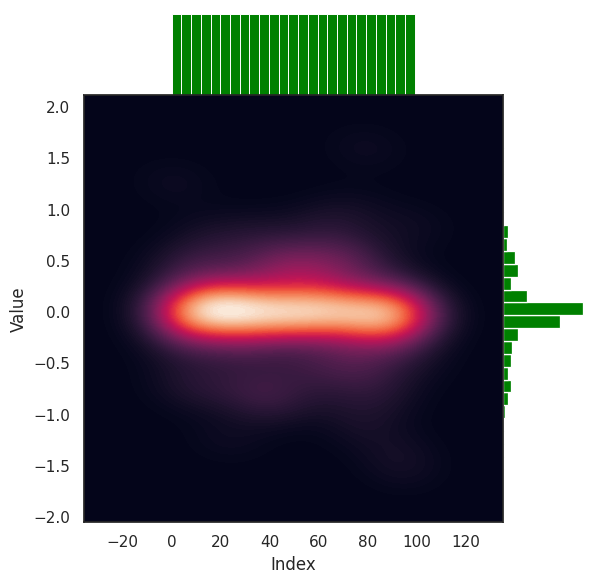

In [89]:
import seaborn as sns
sns.set_theme(style="white")

#df = sns.load_dataset("penguins")

g = sns.JointGrid(data=df, x="Index", y="Value", space=0)
g.plot_joint(sns.kdeplot,
             fill=True,
             thresh=0, levels=100, cmap="rocket",color='blue')
g.plot_marginals(sns.histplot, color="green", alpha=1, bins=25)

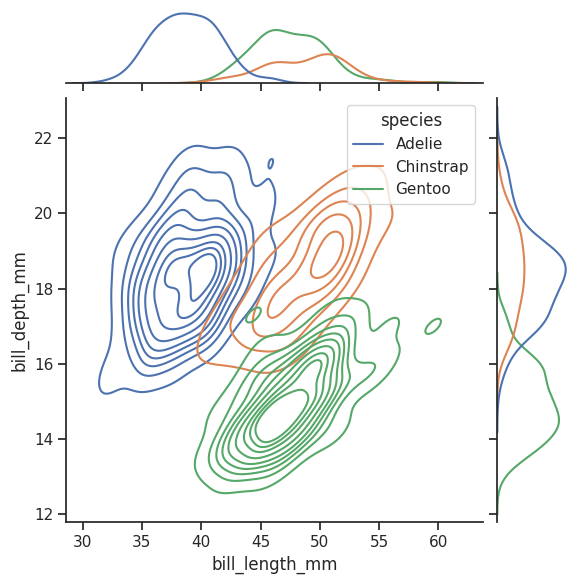

In [73]:
import seaborn as sns
sns.set_theme(style="ticks")

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=penguins,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    kind="kde",
)

In [66]:
feature_vector_2.shape

(100,)

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your feature vectors stored in variables 'text_feature_vector' and 'amr_feature_vector'
# Assuming you have your true labels stored in variables 'labels1' and 'labels3'

sns.stripplot(x=range(len(text_amr_feature_vector[2629][:100][0])), y=text_amr_feature_vector[2629][:100][0], color='blue', jitter=True)
sns.stripplot(x=range(len(text_amr_feature_vector[2629][100:][0])), y=text_amr_feature_vector[2629][100:][0], color='green', jitter=True)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.ylim(-0.2, 0.15)
plt.title('Strip Plot - Feature Vector 3')
plt.show()



# Line plot for feature_vector2
sns.lineplot(x=range(len(amr_feature_vector[2629][0])), y=amr_feature_vector[2629][0], color='green')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Line Plot - Feature Vector 2')
plt.show()


# Violin plot for feature_vector3
sns.lineplot(x=range(len(text_amr_feature_vector[2629][:100][0])), y=text_amr_feature_vector[2629][:100][0], color='blue')
sns.lineplot(x=range(len(text_amr_feature_vector[2629][100:][0])), y=text_amr_feature_vector[2629][100:][0], color='green')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.ylim(-0.2, 0.15)
plt.title('Violin Plot - Feature Vector 3')
plt.show()


AttributeError: 'bool' object has no attribute 'all'

/DATA/gupta37/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/DATA/gupta37/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/DATA/gupta37/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/DATA/gupt

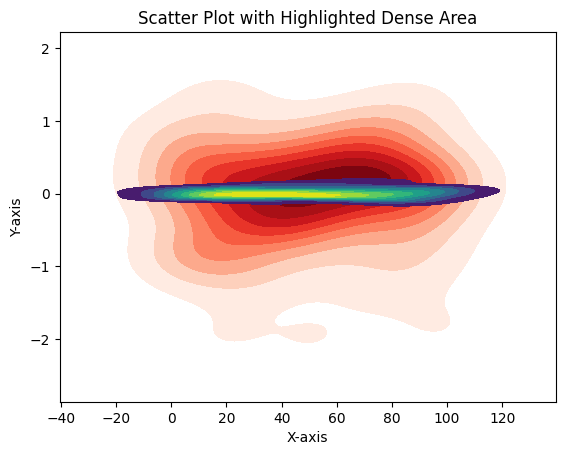

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a scatter plot
sns.scatterplot(range(len(text_amr_feature_vector[2629][:100][0])), text_amr_feature_vector[2629][:100][0])
# Create a scatter plot
sns.scatterplot(range(len(text_amr_feature_vector[2629][100:][0])), text_amr_feature_vector[2629][100:][0])
# Estimate the density using KDE
sns.kdeplot(range(len(text_amr_feature_vector[2629][:100][0])), text_amr_feature_vector[2629][:100][0], cmap='Reds', shade=True, shade_lowest=False)
sns.kdeplot(range(len(text_amr_feature_vector[2629][100:][0])), text_amr_feature_vector[2629][100:][0], cmap='viridis', shade=True, shade_lowest=False)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Highlighted Dense Area')

plt.show()


In [62]:
len(text_feature_vector[52].flatten())

10000

In [138]:
len(np.concatenate(([X_test,np.array(x_g_test)][0][30], [X_test,np.array(x_g_test)][1][30][0]),axis=0))

200

In [139]:
X_test[30]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 1813,  334,    1, 1546, 2171, 2550,  967,  466,
         32], dtype=int32)

# BiLSTM

In [96]:
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
layer1 =Bidirectional(LSTM(units=32, return_sequences=True))(embed1)
layer2 = Bidirectional(LSTM(units=16))(layer1)
layer3 = Dense(units=64, activation='relu')(layer2)
layer4 = Dropout(0.2)(layer3)
layer5 = Dense(1, activation='sigmoid')(layer4)
model_bilstm = Model(input1, layer5)
model_bilstm.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/DATA/gupta37/.local/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [97]:
model_bilstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          823100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 64)          34048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0   

In [98]:
history_bilstm = model_bilstm.fit(x_train, y_train, batch_size = batch_size , validation_split = .2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.7963WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0ee1ba5ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

In [99]:
y_pred = (model_bilstm.predict(X_test) > 0.7).astype("int32")

accuracy_score(y_test,y_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - 4s 25ms/step


0.9136448598130841

In [100]:
print(classification_report(y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.87372   0.95378   0.91200      1255
           1    0.95556   0.87817   0.91523      1420

    accuracy                        0.91364      2675
   macro avg    0.91464   0.91598   0.91361      2675
weighted avg    0.91716   0.91364   0.91371      2675



In [62]:
input1=Input(shape=(maxlen,))
embed1=Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input1)
input2=Input(shape=(max_sent_len,100,))
#reshaped_input_2 = Reshape((1, 100))(input2)
feature =  Concatenate(axis=1)([embed1, input2])
layer1 =Bidirectional(LSTM(units=32, return_sequences=True))(feature)
layer2 = Bidirectional(LSTM(units=16))(layer1)
layer3 = Dense(units=64, activation='relu')(layer2)
layer4 = Dropout(0.2)(layer3)
layer5 = Dense(1, activation='sigmoid')(layer4)
model_bilstm_graph = Model([input1, input2], layer5)
model_bilstm_graph.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/DATA/gupta37/.local/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [63]:
model_bilstm_graph.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 100)     823100      ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 7, 100)]     0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 107, 100)     0           ['embedding_5[0][0]',            
                                                                  'input_9[0][0]']          

In [64]:
history_bilstm_graph = model_bilstm_graph.fit([x_train,np.array(x_g_train)], y_train, batch_size = batch_size , validation_split=0.2 , epochs = epochs , callbacks = [learning_rate_reduction, early_stopping])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.7832WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb35836a488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

In [67]:
y_pred = (model_bilstm_graph.predict([X_test,np.array(x_g_test)]) > 0.5).astype("int32")

accuracy_score(y_test,y_pred)

84/84 [==============================] - 2s 27ms/step


0.9244859813084112

In [68]:
print(classification_report(y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.91294   0.92749   0.92016      1255
           1    0.93500   0.92183   0.92837      1420

    accuracy                        0.92449      2675
   macro avg    0.92397   0.92466   0.92426      2675
weighted avg    0.92465   0.92449   0.92452      2675



In [101]:
file1=pd.read_excel(r'./africa_data/Fake News (mzanzi stories) Fake.xlsx', header=None)
file2=pd.read_excel(r'./africa_data/Fake News (sa-news.com) Fake.xlsx', header=None)
file3=pd.read_excel(r'./africa_data/Fake News (search67.com) Fake.xlsx', header=None)
file4=pd.read_excel(r'./africa_data/Fake News (whatsappgroup.co.za) Fake.xlsx', header=None)

In [102]:
afr_test_df = pd.DataFrame(pd.concat([file1[5], file2[5], file3[5],file4[5]], axis=0))

# Reset the index of the combined dataframe
afr_test_df.reset_index(drop=True, inplace=True)
afr_test_df = afr_test_df.rename(columns={5: 'tweet'})
afr_test_df['label']= 0

In [103]:
afr_test_df['tweet']= afr_test_df['tweet'].apply(lambda x :str(x))

In [104]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
afr_test_df['tweet']=afr_test_df['tweet'].apply(denoise_text)

def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(afr_test_df.tweet)


def get_max_len(text):
    words_len = []
    for i in text:
        words=[]
        for j in i.split():
            words.append(j.strip())
        words_len.append(len(words))
    return words_len
max_len = max(get_max_len(afr_test_df.tweet))

max_len

/DATA/gupta37/.local/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


1506

In [105]:
max_features = 8231
maxlen = 100
max_sent_len=7


tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(afr_test_df['tweet'])
tokenized_train = tokenizer.texts_to_sequences(afr_test_df['tweet'])
x_afr_test = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

# tokenized_test = tokenizer.texts_to_sequences(x_test)
# X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# EMBEDDING_FILE = './glove.twitter.27B.100d.txt'

# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

# all_embs = np.stack(embeddings_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]



In [106]:
# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# #change below line if computing normal stats is too slow
# embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [107]:
x_afr_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   54,
         28,  838,   28, 6694,   28, 1453, 3556,  130,   16,  263, 6694,
        144, 1930,   33,   72,  564,   72, 5653,  167,    2, 1521, 6695,
       3908, 1401, 1049,   28,  184, 3253,   28,   55,  578,   54, 1654,
         28, 6694,  578, 1016, 5654,   41,  137,   28,   91,  137,   28,
         45], dtype=int32)

In [108]:
y_pred = (model_bilstm.predict(x_afr_test) > 0.5).astype("int32")

accuracy_score(afr_test_df['label'],y_pred)

23/23 [==============================] - 1s 25ms/step


0.39389736477115117

In [110]:
y_pred

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
    